## SRJ - Adapt repetitive

In [1]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad_old=[]

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        print('Updated hf_state is', hf_state)  
        qml.BasisState(hf_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, hf_state, H):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]]  #Appln of HF state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(hf_state, ash_excitation, params):
        [qml.PauliX(i) for i in np.nonzero(hf_state)[0]] #Applying the HF state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, hf_state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [hf_state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, hf_state): # If the current state is the HF state
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        #print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad_old.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization
            #print('Parameters are', params)
        else:
            params = np.append(params, 0.0) 
            #print('Parameters before optimization are', params)


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})

        #print("Final updated parameters:", result.x)
        #print("Final cost:", result.fun)

        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(hf_state, ash_excitation, params)
        #print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits, grad_old


In [2]:
energies, params, ash_excitation, gs_state,H, qubits, grad_old = adaptvqe(adapt_it = 5, e_th=1e-12)
print('Energies:', energies)
print('Gradients:', grad_old)

Updated hf_state is [1 1 1 1 0 0 0 0]
HF state is -1.332568888066893
The adapt iteration now is 0


/Users/s.poyyapakkam/miniconda3/envs/ashsri/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [1.12299215]
Current cost: -1.4300836708403135

Current parameters: [1.12299279]
Current cost: -1.4300836708403395

Optimization terminated successfully.
         Current function value: -1.430084
         Iterations: 2
         Function evaluations: 79
Updated params are [1.12299279]
Updated excitation are [[2, 3, 6, 7]]
The adapt iteration now is 1
Highest gradient excitation is [0, 3, 5, 6]
Current parameters: [1.12299268 1.38120324]
Current cost: -1.5693729295710581

Current parameters: [1.09743885 1.37779486]
Current cost: -1.5694603734962098

Current parameters: [1.09716182 1.37775789]
Current cost: -1.5694603835520702

Optimization terminated successfully.
         Current function value: -1.569460
         Iterations: 3
         Function evaluations: 203
Updated params are [1.09716182 1.37775789]
Updated excitation are [[2, 3, 6, 7], [0, 3, 5, 6]]
The adapt iteration now is 2
Highest gradient excitation is [0, 1, 4

In [4]:
import pennylane as qml

# Initialize device with 1000 shots
dev4 = qml.device("lightning.qubit", wires=qubits, shots=1000)

@qml.qnode(dev4)
def measurement(gs_state):
    qml.StatePrep(gs_state, wires=range(qubits))
    return qml.counts(all_outcomes = False)  # Samples all qubits

counts = measurement(gs_state)
print(counts)
#Highest probability state : |11110000>
#1 Adapt : HF state
#2 Adapt : |11110000> state
#3 Adapt : |01100110>
#4 Adapt : |11110000> - 2808
#5 Adapt : |11110000> - 2781
#7 Adapt : |11110000> - 1949

# 10 Adapt - lowest count : |00101101> - 21 counts
#11000011 - 266 
#01100110 - 322

{'00001111': 186, '00111100': 124, '01001011': 6, '01100110': 111, '01111000': 2, '10000111': 3, '10011001': 126, '10110100': 6, '11000011': 121, '11110000': 315}


In [6]:
import numpy as np
cstate = np.array([0, 0, 1, 0, 1, 1, 0, 1])
c2state = np.array([0,1,1,1,1,0,0,0])
hf_state = np.array([1,1,1,1,0,0,0,0])

## Adding lowest count state instead of HF state

In [7]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe_updated(c2state,adapt_it = 4, e_th=1e-12):
    print('checking input',c2state)
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(c2state, electrons, qubits, H):
        print('Updated c2state is', c2state)  
        qml.BasisState(c2state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.BasisState(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, c2state, H):
        #print('Updated c2state is', c2state)
        qml.BasisState(c2state, wires=range(qubits))  #Applying the c state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(c2state, ash_excitation, params):
        #print('Updated c2state is', c2state)
        qml.BasisState(c2state, wires=range(qubits))  #Applying the c state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, c2state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('c2 state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [c2state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else c2state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, c2state): # If the current state is the HF state
                print('Current state is c state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization

        else:
            params = np.append(params, 0.0) 
 


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})


        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(c2state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(c2state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits


In [8]:
energies, params, ash_excitation, gs_state,H, qubits = adaptvqe_updated(c2state, adapt_it = 10, e_th=1e-12)
print('Energies:', energies)
print('Gradient:', grad)    

checking input [0 1 1 1 1 0 0 0]
Updated c2state is [1 1 1 1 0 0 0 0]
c2 state is -1.332568888066893
The adapt iteration now is 0
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
Current state is c state
The highest operator value is 0.3100451588582116 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
Current parameters: [1.40869024]
Current cost: -1.397154199593659

Current parameters: [1.40

In [1]:
import numpy as np

grad_old = np.array([0.3100451588582116,
 0.3633341735468966,
 0.4247574427326104,
 0.2689427987570283,
 0.11800199769360024])

energy_old = np.array([-1.4300836708403395, -1.5694603835520702, -1.7436334426139477, -1.842110151422438, -1.8504359311254426])

grad = np.array([0.3100451588582116,
 0.20714459107798083,
 0.2021608687892275,
 0.3016931609731706,
 0.1653013876219778,
 0.20190780890925086,
 0.09632043477478623,
 0.09674047051864337,
 0.08940194038034947,
 0.0902784985574107])

energy = np.array([-1.3971541995936787, -1.4733966692143903, -1.5447146417606672, -1.7131821745076246, -1.759660983456068, -1.8703479723166552, -1.8740449424691508, -1.877738551462107, -1.8808969386837455, -1.8840867425893866])

[0.3100451588582116, 0.3633341735468966, 0.4247574427326104, 0.2689427987570283, 0.11800199769360024, 0.3100451588582116, 0.20714459107798083, 0.2021608687892275, 0.3016931609731706, 0.1653013876219778, 0.20190780890925086, 0.09632043477478623, 0.09674047051864337, 0.08940194038034947, 0.0902784985574107]
[-1.4300836708403395, -1.5694603835520702, -1.7436334426139477, -1.842110151422438, -1.8504359311254426, -1.3971541995936787, -1.4733966692143903, -1.5447146417606672, -1.7131821745076246, -1.759660983456068, -1.8703479723166552, -1.8740449424691508, -1.877738551462107, -1.8808969386837455, -1.8840867425893866]


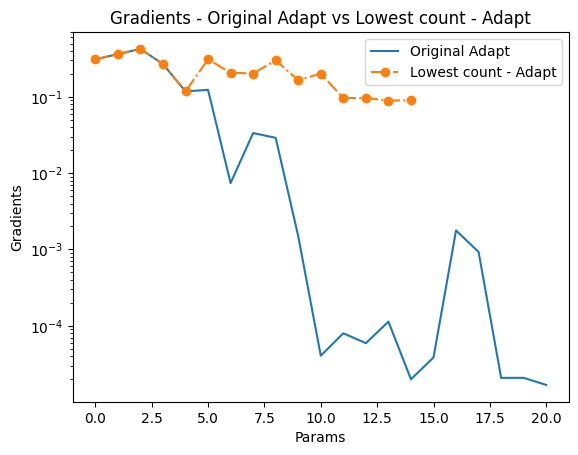

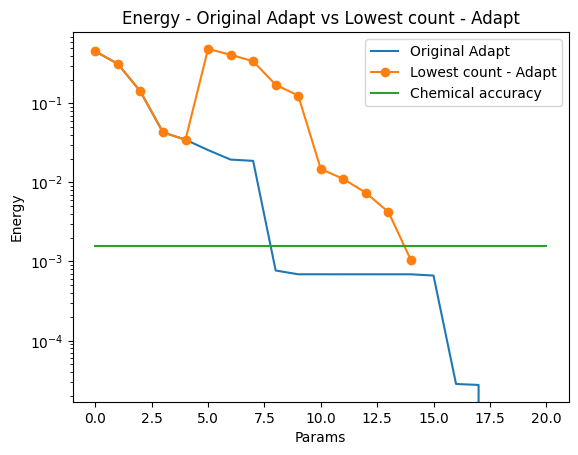

In [14]:
grad_updated = []
energy_updated = []
Distance_updated = np.arange(0,15,1.0)

Distance_Exact = np.arange(0,21,1.0)

G_Exact = (0.3100451588582116 , 0.36333417728273754, 0.4247574417703076, 0.2689421354231678, 0.11800197933700611, 0.12345368822802208,
            0.007420281812857612, 0.03354563739855884 , 0.029061752158627868, 0.0014907673809587962, 4.058027986704677e-05, 7.976896690634755e-05,
            5.913441683514514e-05, 0.00011328401551519846, 1.989246929409716e-05, 3.843530082175278e-05,  0.0017755760879906296, 0.0009282356568736209,
             2.0769533991756538e-05, 2.0776790979757515e-05,1.678514206528755e-05)

E_Exact = np.array([-1.430083652442, -1.569460375668, -1.743633446894,-1.842110157560,
                     -1.850435938949, -1.859460023915,  -1.865676740601, -1.866387973815, 
                       -1.884356032844,-1.884436165205,-1.884436166965,-1.884436452006,
                        -1.884436455459, -1.884436575804,  -1.884436576265,-1.884461256990,
                        -1.885096675950,-1.885097436763,  -1.885124904187, -1.885124904187,
                        -1.885124904187])

FCI_Exact = np.full(21, -1.88512490)
FCI_Updated = np.full(15, -1.88512490)

chem_accuracy = np.full(21, 1.59e-3)
#print(FCI)

grad_updated.extend(grad_old)
grad_updated.extend(grad)
print(grad_updated)


energy_updated.extend(energy_old)
energy_updated.extend(energy)
print(energy_updated)

Error_Exact = np.array(E_Exact - FCI_Exact)
Error_Updated = np.array(energy_updated - FCI_Updated)

import matplotlib.pyplot as plt
plt.plot(Distance_Exact, G_Exact, '-', label = 'Original Adapt')
plt.plot(Distance_updated, grad_updated, '-.o', label = 'Lowest count - Adapt')
plt.legend()
plt.yscale('log')
#plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Gradients')
plt.title('Gradients - Original Adapt vs Lowest count - Adapt')
plt.show()

plt.plot(Distance_Exact, Error_Exact, '-', label = 'Original Adapt') 
plt.plot(Distance_updated, Error_Updated, '-o', label = 'Lowest count - Adapt') 
plt.plot(Distance_Exact, chem_accuracy, '-', label = 'Chemical accuracy') 
plt.legend()
#plt.xlim(0,11)
plt.xlabel ('Params')
plt.ylabel('Energy')
plt.yscale('log')
plt.title('Energy - Original Adapt vs Lowest count - Adapt')
plt.show()

In [19]:
print('HF state:',hf_state)
print('c2 state:',c2state)
print(qubits)


HF state: [1 1 1 1 0 0 0 0]
c2 state: [0 1 1 1 1 0 0 0]
8


## Givens rotation : Generated combined states

In [23]:
import pennylane as qml
import numpy as np

dev = qml.device("lightning.qubit", wires=8)

@qml.qnode(dev)
def givens_circuit(theta):
    # Prepare |1100⟩
    qml.BasisEmbedding(hf_state, wires=range(qubits))
    
    # Apply Givens rotation between |1100⟩ and |0011⟩
    qml.SingleExcitation(theta, wires=[0,4])  # Generalized Givens rotation
    
    return qml.state()

# Example: Equal superposition (θ=π/4)
theta = np.pi/2
comb_state = givens_circuit(theta)
#print(f"State: {comb_state}")
qubits=8

dev4 = qml.device("lightning.qubit", wires=qubits, shots=1000)
@qml.qnode(dev4)
def measurement(comb_state):
    qml.StatePrep(comb_state, wires=range(qubits))
    return qml.counts(all_outcomes = False)  # Samples all qubits

counts = measurement(comb_state)
print(counts)


{'01111000': 506, '11110000': 494}


In [30]:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import time
import re
from scipy.optimize import minimize
ash_excitation = []
energies = []
excitations= []
grad_comb = []

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886  
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)




def adaptvqe_updated(comb_state,adapt_it = 4, e_th=1e-12):
    print('checking input',comb_state)
    ash_excitation = []
    energies = []
    excitations= []
    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(comb_state, electrons, qubits, H):
        print('Updated comb_state is', comb_state)  
        qml.StatePrep(comb_state, wires=range(qubits))
        return qml.expval(H)   #Calculating the expectation value of the Hamiltonian
    
    # Commutator calculation for HF state
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)

    #Energy calculation 
    @qml.qnode(dev)
    def ash(params, ash_excitation, comb_state, H):
        print('Updated comb_state is', comb_state)
        qml.BasisState(comb_state, wires=range(qubits))  #Applying the c state
        for i, excitation in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.expval(H)  #Calculating the expectation value of the Hamiltonian
    
    # Calculation of New state, same as the above function but with the state return
    dev1 = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev1)
    def new_state(comb_state, ash_excitation, params):
        print('Updated comb_state in prep new state is', comb_state)
        qml.StatePrep(comb_state, wires=range(qubits))  #Applying the c state
        for i, excitations in enumerate(ash_excitation):
            if len(ash_excitation[i]) == 4:
                qml.FermionicDoubleExcitation(weight=params[i], wires1=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)), wires2=list(range(ash_excitation[i][2], ash_excitation[i][3] + 1)))
            elif len(ash_excitation[i]) == 2:
                qml.FermionicSingleExcitation(weight=params[i], wires=list(range(ash_excitation[i][0], ash_excitation[i][1] + 1)))
        return qml.state()
    
    def cost(params):
        energy = ash(params, ash_excitation, c2state, H)
        return energy

    def callback(params):
        print(f"Current parameters: {params}")
        print(f"Current cost: {cost(params)}\n")
    

    print('comb state is', circuit(comb_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    states = [comb_state]
    

    for j in range(adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        max_operator = None
        k = states[-1] if states else comb_state  # if states is empty, fall back to hf_state
       
        for i in operator_pool:
            w = qml.fermi.jordan_wigner(i)  #JW transformation
            if np.array_equal(k, comb_state): # If the current state is the HF state
                print('Current state is comb_state')
                current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
            else:
                current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
            #print(f'The expectation value of {i} is', current_value)

            if current_value > max_value:
                max_value = current_value
                max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        grad_comb.append(max_value)
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations)
        ash_excitation.append(excitations) #Appending the excitations to the ash_excitation
        if j == 0:
            params = qml.numpy.zeros(len(ash_excitation), requires_grad=True)  #Parameters initialization

        else:
            params = np.append(params, 0.0) 
 


        #Energy calculation
        result = minimize(cost, params, method='powell', callback=callback, tol = e_th, options = {'disp': True, 'maxiter': 1e8, 'xtol':1e-8, 'ftol':1e-8})


        params= (result.x)
        energies.append(result.fun)
        print('Updated params are', params)
        print('Updated excitation are', ash_excitation)

        # New state generation - With the updated parameters
        ostate = new_state(comb_state, ash_excitation, params)
        print(qml.draw(new_state, max_length=100)(comb_state,ash_excitation,params))
        gs_state = ostate
        # Append the new state to the states list
        states.append(ostate)

    return energies, params, ash_excitation, gs_state, H, qubits


In [31]:
energies, params, ash_excitation, gs_state,H, qubits = adaptvqe_updated(comb_state, adapt_it = 10, e_th=1e-12)
print('Energies:', energies)
print('Gradient:', grad_comb)    

checking input [ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.      

/Users/s.poyyapakkam/miniconda3/envs/ashsri/lib/python3.11/site-packages/pennylane_lightning/core/_serialize.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  coeffs = np.array(coeffs).astype(self.rtype)


Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
Current state is comb_state
The highest operator value is 0.35215966684735844 for operator a⁺(3) a(7)
Highest gradient excitation is [3, 7]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Updated comb_state is [0 1 1 1 1 0 0 0]
Current parameters: [1.01147753]
Updated comb_state is [